## 1st Try:
### PatchTST & TemporalFusionTransformer with combined_data.parquet
##### 1/19/2025

In [ ]:
# !pip install uv
# !uv pip install -q autogluon.timeseries --system
# !uv pip uninstall -q torchaudio torchvision torchtext --system # fix incompatible package versions on Colab

### packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from autogluon.timeseries.models import PatchTSTModel, TemporalFusionTransformerModel
from plotnine import *
from autogluon.common import space

### data

In [4]:
df = pd.read_parquet("../../combined_data/combined_data.parquet")
df.head()

,T_REC,USFLUX,MEANGAM,MEANGBT,MEANGBZ,MEANGBH,MEANJZD,TOTUSJZ,MEANALP,MEANJZH,...,NPIX,SIZE,AREA,NACR,SIZE_ACR,AREA_ACR,flux,max_flux_next_24h,max_flare_class_next_24h,max_peak_intensity_next_24h
0,2010-05-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.615019e-08,0.000008,C,0.000008
1,2010-05-01 00:12:00+00:00,1.439345e+21,32.159885,137.783195,137.832428,59.383249,0.528793,2.065877e+12,0.001307,-0.000677,...,21385.121136,1908.233367,1124.079598,1636.651525,146.041405,86.298480,6.331756e-08,0.000008,C,0.000008
2,2010-05-01 00:24:00+00:00,1.488903e+21,32.006564,138.032814,137.932202,58.588763,0.355526,2.096785e+12,0.001291,-0.000588,...,22631.582458,2019.510773,1188.056979,1754.132156,156.528544,92.311965,6.583243e-08,0.000008,C,0.000008
3,2010-05-01 00:36:00+00:00,1.495132e+21,32.489844,136.413847,136.048735,59.049505,0.317466,2.190448e+12,-0.001002,-0.001128,...,23156.134658,2066.389478,1214.339188,1786.976723,159.464861,93.905701,7.199385e-08,0.000008,C,0.000008
4,2010-05-01 00:48:00+00:00,1.566065e+21,31.843583,136.656334,136.326496,58.237536,0.342064,2.305668e+12,-0.000914,-0.000872,...,24186.736691,2158.422429,1267.802766,1847.651398,164.884269,97.054212,6.824671e-08,0.000008,C,0.000008


In [ ]:
df.dtypes

T_REC                          datetime64[ns, UTC]
USFLUX                                     float64
MEANGAM                                    float64
MEANGBT                                    float64
MEANGBZ                                    float64
MEANGBH                                    float64
MEANJZD                                    float64
TOTUSJZ                                    float64
MEANALP                                    float64
MEANJZH                                    float64
TOTUSJH                                    float64
ABSNJZH                                    float64
SAVNCPP                                    float64
MEANPOT                                    float64
TOTPOT                                     float64
MEANSHR                                    float64
SHRGT45                                    float64
NPIX                                       float64
SIZE                                       float64
AREA                           

### PatchTST Model
Transformer-based forecaster that segments each time series into patches
- Prediction length: 1000

In [5]:
df_single_item = df.copy()
df_single_item['item_id'] = 0
df_single_item = df_single_item[[df_single_item.columns[-1]] + list(df_single_item.columns[:-1])]
df_single_item.rename(columns={'T_REC':'timestamp'}, inplace=True)
df_single_item['timestamp'] = df_single_item['timestamp'].dt.tz_localize(None)

df_single_item = df_single_item.ffill() # fill missing values with previous one
df_single_item = df_single_item.iloc[1:,] # drop the 1st row

df_single_item = df_single_item.iloc[:, 0:-3]
df_single_item = df_single_item.iloc[:11000,:]
df_single_item["target"] = df_single_item["USFLUX"]

df_single_item = TimeSeriesDataFrame.from_data_frame(df_single_item)

prediction_length = 1000 # smaller prediction_length performs better

train_data, test_data = df_single_item.train_test_split(prediction_length)

print(len(train_data), len(test_data))


10000 11000


In [ ]:
df_single_item

In [ ]:
df_single_item.columns

Index(['USFLUX', 'MEANGAM', 'MEANGBT', 'MEANGBZ', 'MEANGBH', 'MEANJZD',
       'TOTUSJZ', 'MEANALP', 'MEANJZH', 'TOTUSJH', 'ABSNJZH', 'SAVNCPP',
       'MEANPOT', 'TOTPOT', 'MEANSHR', 'SHRGT45', 'NPIX', 'SIZE', 'AREA',
       'NACR', 'SIZE_ACR', 'AREA_ACR', 'flux', 'target'],
      dtype='object')

In [ ]:
known_covariates_names = df_single_item.columns[
    1:4
]
known_covariates_names

Index(['MEANGAM', 'MEANGBT', 'MEANGBZ'], dtype='object')

In [ ]:
predictor = TimeSeriesPredictor(
    freq = "12T",
    prediction_length= prediction_length, # 1000
    # known_covariates_names= known_covariates_names,
).fit(
    train_data,
    hyperparameters={
        "PatchTST": [
            {
                "target_scaler": "standard",
             
            }
        ]
    },

    enable_ensemble= False,
    time_limit= 120,
)

No path specified. Models will be saved in: "AutogluonModels\ag-20250128_041424"
c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\autogluon\timeseries\predictor.py:197: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
Frequency '12T' stored as '12min'
Beginning AutoGluon training... Time limit = 120s
AutoGluon will save models to 'c:\Users\Administrator\Desktop\URPS\urps_2025\notebooks\Jingyi_notebooks\AutogluonModels\ag-20250128_041424'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          16
GPU Count:          0
Memory Avail:       3.22 GB / 15.73 GB (20.4%)
Disk Space Avail:   65.20 GB / 200.00 GB (32.6%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'freq': '12min',
 'hyperparameters': {'PatchTST': [{'target_scaler': 'standard'}]},
 'know

In [ ]:
predictor.leaderboard(test_data)

data with frequency 'None' has been resampled to frequency '12min'.
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,PatchTST,-0.427658,-0.530565,0.137602,0.067998,105.970764,1


In [ ]:
y_bar = predictor.predict(train_data)["mean"]
# y_bar

data with frequency 'None' has been resampled to frequency '12min'.
Model not specified in predict, will default to the model with the best validation score: PatchTST


In [ ]:
plot_df = pd.DataFrame( {
    "pred" : y_bar,
    "actual": test_data["target"].iloc[-prediction_length:,]
})

plot_df.reset_index(inplace=True)

In [ ]:
plot_df[["pred", "actual"]] = plot_df[["pred", "actual"]] / 1e21

In [ ]:
#plot_df

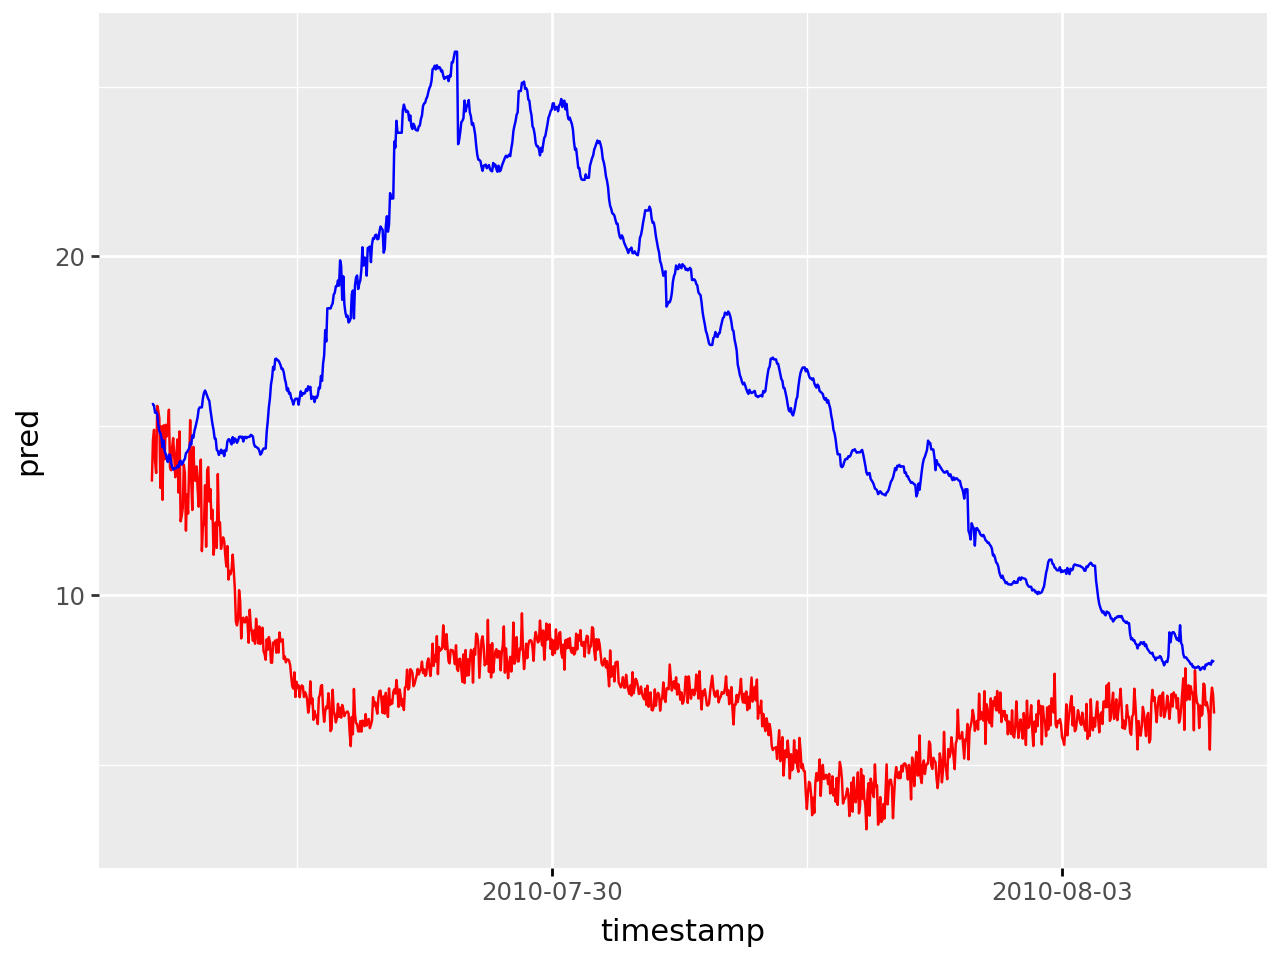

In [ ]:
(
    ggplot(data=plot_df, mapping= aes(x= "timestamp")) +
    geom_line(aes(y = "pred"), color = "red") + 
    geom_line(aes(y = "actual"), color = "blue")
)

data with frequency 'None' has been resampled to frequency '12min'.
Model not specified in predict, will default to the model with the best validation score: PatchTST\90afc027
data with frequency 'None' has been resampled to frequency '12min'.


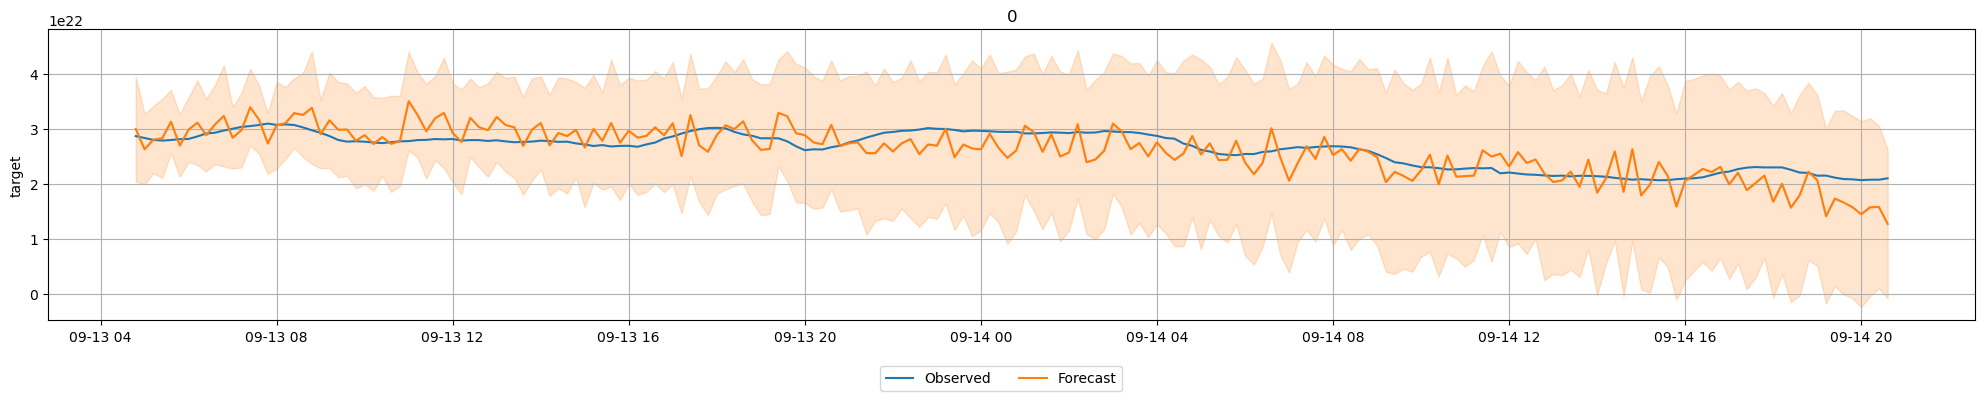

In [ ]:
predictor.plot(
    test_data, 
    predictor.predict(train_data), 
    quantile_levels = [0.3, 0.7],
    max_history_length = 200
    )

### PatchTST Model Part 2.1
only use USFLUX (target) to predict
- smaller prediction length, better performance
- compared with hyperparameter auto tuning

In [ ]:
df_single_item = df.copy()
df_single_item['item_id'] = 0
df_single_item = df_single_item[[df_single_item.columns[-1]] + list(df_single_item.columns[:-1])]
df_single_item.rename(columns={'T_REC':'timestamp'}, inplace=True)
df_single_item['timestamp'] = df_single_item['timestamp'].dt.tz_localize(None)

df_single_item = df_single_item.ffill() # fill missing values with previous one
df_single_item = df_single_item.iloc[1:,] # drop the 1st row

df_single_item = df_single_item.iloc[:, 0:-3]
df_single_item = df_single_item.iloc[:12000,:]
df_single_item["target"] = df_single_item["USFLUX"]
df_single_item = df_single_item.drop(
    columns= [
        'USFLUX', 'MEANGAM', 'MEANGBT', 'MEANGBZ', 'MEANGBH', 'MEANJZD',
       'TOTUSJZ', 'MEANALP', 'MEANJZH', 'TOTUSJH', 'ABSNJZH', 'SAVNCPP',
       'MEANPOT', 'TOTPOT', 'MEANSHR', 'SHRGT45', 'NPIX', 'SIZE', 'AREA',
       'NACR', 'SIZE_ACR', 'AREA_ACR', 'flux', 
    #    'target'
       ])   
df_single_item = TimeSeriesDataFrame.from_data_frame(df_single_item)

prediction_length = 200 # smaller prediction_length performs better

train_data, test_data = df_single_item.train_test_split(prediction_length)

print(len(train_data), len(test_data))

11800 12000


In [ ]:
train_data

target
item_id timestamp                        
0       2010-05-01 00:12:00  1.439345e+21
        2010-05-01 00:24:00  1.488903e+21
        2010-05-01 00:36:00  1.495132e+21
        2010-05-01 00:48:00  1.566065e+21
        2010-05-01 01:00:00  1.581636e+21
...                                   ...
        2010-08-10 19:48:00  5.469793e+21
        2010-08-10 20:00:00  5.572276e+21
        2010-08-10 20:12:00  5.628117e+21
        2010-08-10 20:24:00  5.659879e+21
        2010-08-10 20:36:00  5.711631e+21

[11800 rows x 1 columns]

1. Without Hyperparameter auto tuning

In [ ]:
predictor = TimeSeriesPredictor(
    freq = "12T",
    prediction_length= prediction_length, # 200
    # known_covariates_names= known_covariates_names,
).fit(
    train_data,
    hyperparameters={
        "PatchTST": [

            {
                "target_scaler": "standard",
            }

        ]
    },

    enable_ensemble= False,
    time_limit= 120,
    num_val_windows = 3 # validation
    # 'eval_metric': WQL # weighted quantile loss / pinball loss: scale-dependent & probabilistic
)

No path specified. Models will be saved in: "AutogluonModels\ag-20250128_141319"
c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\autogluon\timeseries\predictor.py:197: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
Frequency '12T' stored as '12min'
Beginning AutoGluon training... Time limit = 120s
AutoGluon will save models to 'c:\Users\Administrator\Desktop\URPS\urps_2025\notebooks\Jingyi_notebooks\AutogluonModels\ag-20250128_141319'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          16
GPU Count:          0
Memory Avail:       5.60 GB / 15.73 GB (35.6%)
Disk Space Avail:   62.72 GB / 200.00 GB (31.4%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'freq': '12min',
 'hyperparameters': {'PatchTST': [{'target_scaler': 'standard'}]},
 'know

In [ ]:
predictor.leaderboard(test_data)

data with frequency 'None' has been resampled to frequency '12min'.
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,PatchTST,-0.086003,-0.088988,0.045998,0.03067,115.557655,1


data with frequency 'None' has been resampled to frequency '12min'.
Model not specified in predict, will default to the model with the best validation score: PatchTST


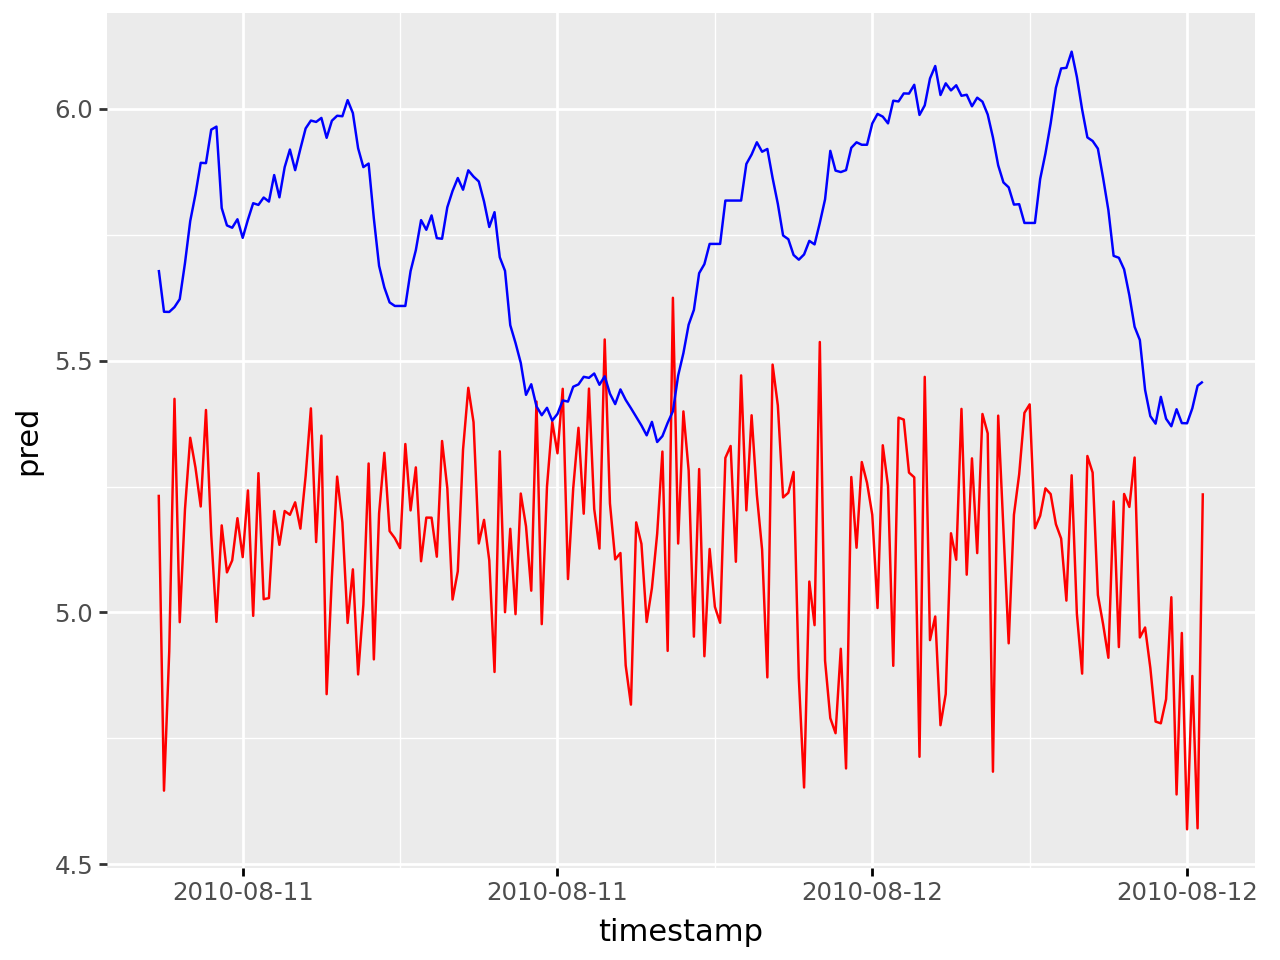

In [ ]:
y_bar = predictor.predict(train_data #,
                        #   known_covariates= test_data[known_covariates_names][-prediction_length:]
                          )["mean"]
plot_df = pd.DataFrame( {
    "pred" : y_bar,
    "actual": test_data["target"].iloc[-prediction_length:,]
})

plot_df.reset_index(inplace=True)

plot_df = pd.DataFrame( {
    "pred" : y_bar,
    "actual": test_data["target"].iloc[-prediction_length:,]
})

plot_df.reset_index(inplace=True)

plot_df[["pred", "actual"]] = plot_df[["pred", "actual"]] / 1e21

(
    ggplot(data=plot_df, mapping= aes(x= "timestamp")) +
    geom_line(aes(y = "pred"), color = "red") + 
    geom_line(aes(y = "actual"), color = "blue")
)

data with frequency 'None' has been resampled to frequency '12min'.
Model not specified in predict, will default to the model with the best validation score: PatchTST
data with frequency 'None' has been resampled to frequency '12min'.


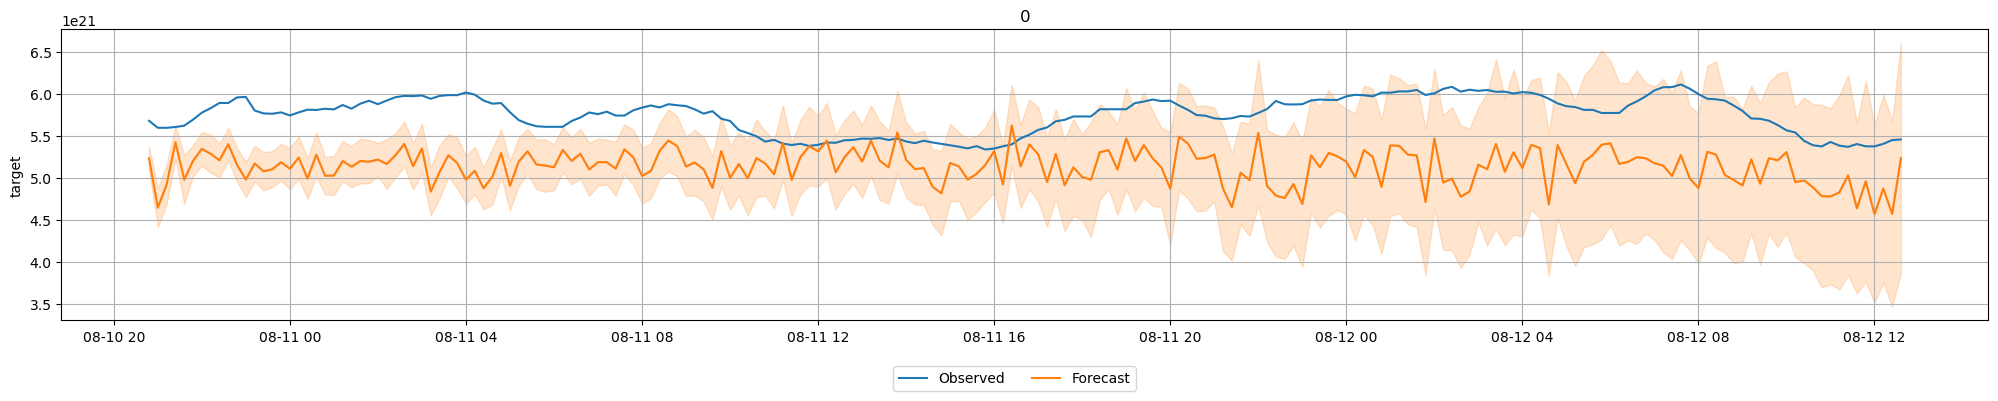

In [ ]:
predictor.plot(
    test_data, 
    predictor.predict(train_data #,
                    #   known_covariates= test_data[known_covariates_names][-prediction_length:]
                      ), 
    quantile_levels = [0.3, 0.7],
    max_history_length = 200
    )

2. With Hyperparameter auto tuning

In [ ]:
predictor = TimeSeriesPredictor(
    freq = "12T",
    prediction_length= prediction_length, # 200
    # known_covariates_names= known_covariates_names,
).fit(
    train_data,
    hyperparameters={
        "PatchTST": [
            {
                "target_scaler": "standard",
                "d_model": space.Int(16,48),
                "nhead": space.Int(2,8),
                "num_encoder_layers": space.Int(2,4),
                "context_length": space.Int(72, 124)
            }

        ]
    },

    hyperparameter_tune_kwargs = "auto",
    enable_ensemble= False,
    time_limit= 120,
    num_val_windows = 3,
    presets = "high_quality",
)

	Trained 8 models while tuning PatchTST.
	-0.0816       = Validation score (-WQL)
	122.12  s     = Total tuning time
Training complete. Models trained: ['PatchTST\\20862f39', 'PatchTST\\8a7819bd', 'PatchTST\\a67597ce', 'PatchTST\\9d7bd62b', 'PatchTST\\592efd28', 'PatchTST\\c13daedd', 'PatchTST\\4f7e1e44', 'PatchTST\\695fad2d']
Total runtime: 122.39 s
Best model: PatchTST\20862f39
Best model score: -0.0816


In [ ]:
predictor.leaderboard(test_data)

data with frequency 'None' has been resampled to frequency '12min'.
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,PatchTST\8a7819bd,-0.057289,-0.096309,0.068999,0.047998,107.367013,2
1,PatchTST\a67597ce,-0.072532,-0.108144,0.048911,0.053999,86.115707,3
2,PatchTST\20862f39,-0.082031,-0.081557,0.032032,0.049999,112.777847,1
3,PatchTST\592efd28,-0.102470,-0.129506,0.049591,0.046999,67.233781,5
4,PatchTST\695fad2d,-0.130530,-0.156693,0.070998,0.030002,22.425923,8
5,PatchTST\4f7e1e44,-0.133101,-0.139456,0.064012,0.028755,38.969574,7
6,PatchTST\9d7bd62b,-0.142261,-0.104871,0.048906,0.059999,83.063673,4
7,PatchTST\c13daedd,-0.181340,-0.135140,0.074001,0.034021,53.774956,6


data with frequency 'None' has been resampled to frequency '12min'.
Model not specified in predict, will default to the model with the best validation score: PatchTST\20862f39
data with frequency 'None' has been resampled to frequency '12min'.


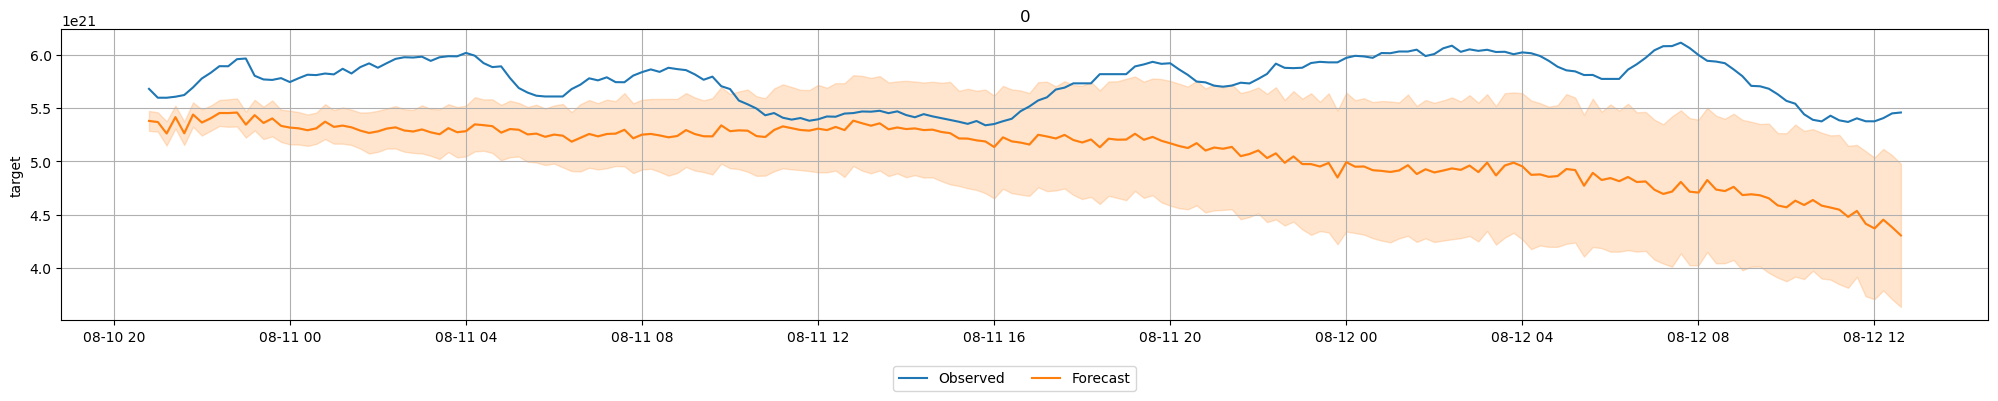

In [ ]:
predictor.plot(
    test_data, 
    predictor.predict(train_data), 
    quantile_levels = [0.3, 0.7],
    max_history_length = 200
    )

data with frequency 'None' has been resampled to frequency '12min'.
Model not specified in predict, will default to the model with the best validation score: PatchTST\20862f39


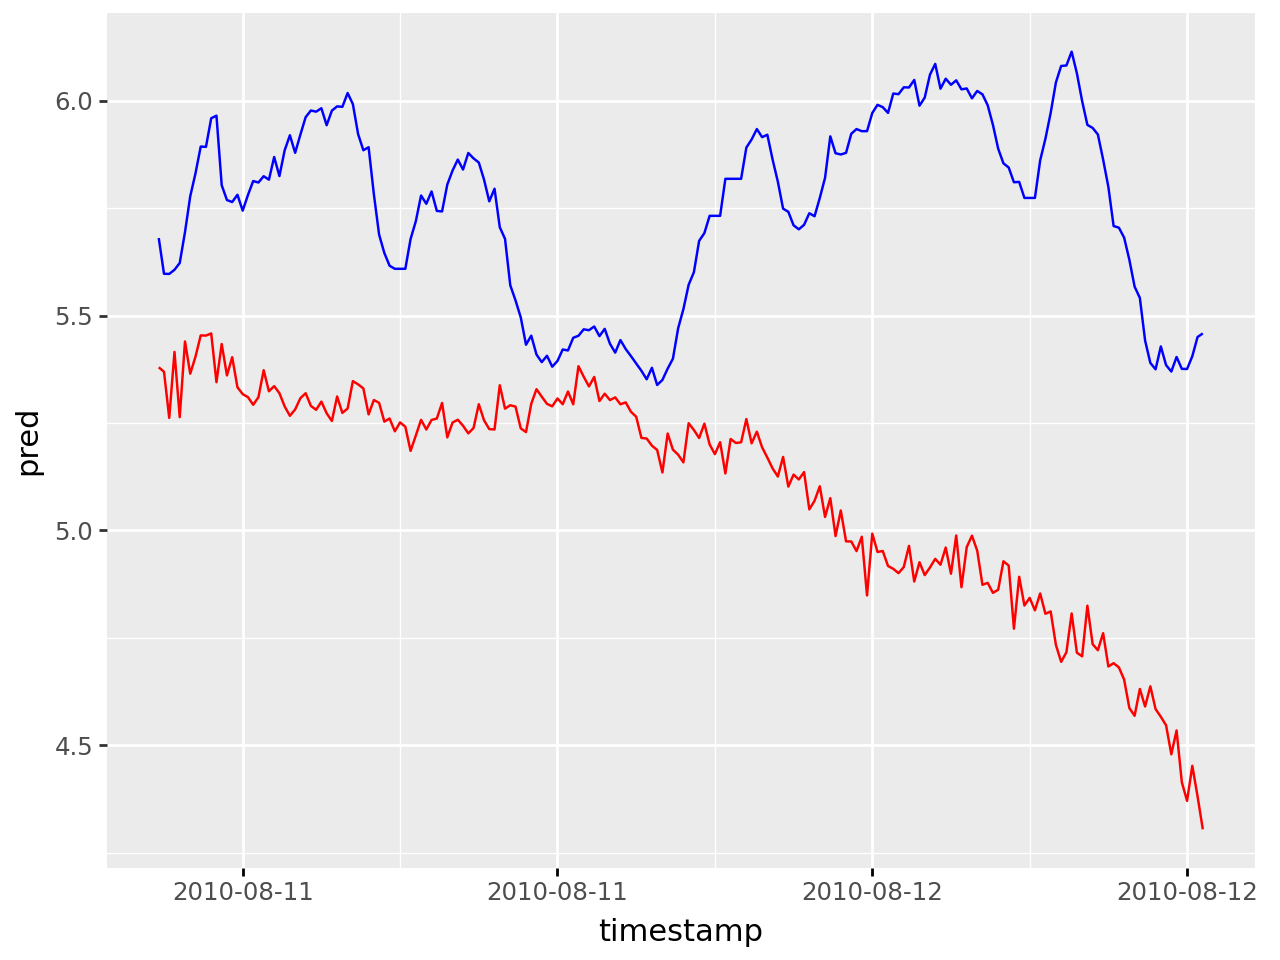

In [ ]:
y_bar = predictor.predict(train_data)["mean"]
plot_df = pd.DataFrame( {
    "pred" : y_bar,
    "actual": test_data["target"].iloc[-prediction_length:,]
})

plot_df.reset_index(inplace=True)

plot_df = pd.DataFrame( {
    "pred" : y_bar,
    "actual": test_data["target"].iloc[-prediction_length:,]
})

plot_df.reset_index(inplace=True)

plot_df[["pred", "actual"]] = plot_df[["pred", "actual"]] / 1e21

(
    ggplot(data=plot_df, mapping= aes(x= "timestamp")) +
    geom_line(aes(y = "pred"), color = "red") + 
    geom_line(aes(y = "actual"), color = "blue")
)

### PatchTST Model Part 2.2
include other variables to predict

In [ ]:
df_single_item = df.copy()
df_single_item['item_id'] = 0
df_single_item = df_single_item[[df_single_item.columns[-1]] + list(df_single_item.columns[:-1])]
df_single_item.rename(columns={'T_REC':'timestamp'}, inplace=True)
df_single_item['timestamp'] = df_single_item['timestamp'].dt.tz_localize(None)

df_single_item = df_single_item.ffill() # fill missing values with previous one
df_single_item = df_single_item.iloc[1:,] # drop the 1st row

df_single_item = df_single_item.iloc[:, 0:-3]
df_single_item = df_single_item.iloc[:20000,:]
df_single_item["target"] = df_single_item["USFLUX"]
df_single_item = df_single_item.drop(
    columns= [
        'USFLUX', #'MEANGAM', 'MEANGBT', 'MEANGBZ', 'MEANGBH', 'MEANJZD',
    #    'TOTUSJZ', 'MEANALP', 'MEANJZH', 'TOTUSJH', 'ABSNJZH', 'SAVNCPP',
    #    'MEANPOT', 'TOTPOT', 'MEANSHR', 'SHRGT45', 'NPIX', 'SIZE', 'AREA',
    #    'NACR', 'SIZE_ACR', 'AREA_ACR', 'flux', 
    #    'target'
       ])   
df_single_item = TimeSeriesDataFrame.from_data_frame(df_single_item)

prediction_length = 1500 # smaller prediction_length performs better

train_data, test_data = df_single_item.train_test_split(prediction_length)

print(len(train_data), len(test_data))

18500 20000


1. Without Hyperparameter auto tuning

In [ ]:
predictor = TimeSeriesPredictor(
    freq = "12T",
    prediction_length= prediction_length, # 200
    # known_covariates_names= known_covariates_names,
).fit(
    train_data,
    hyperparameters={
        "PatchTST": [

            {
                "target_scaler": "standard",
            }

        ]
    },

    enable_ensemble= False,
    time_limit= 120,
    num_val_windows = 3 # validation
    # 'eval_metric': WQL # weighted quantile loss / pinball loss: scale-dependent & probabilistic
)

No path specified. Models will be saved in: "AutogluonModels\ag-20250128_143315"
c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\autogluon\timeseries\predictor.py:197: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
Frequency '12T' stored as '12min'
Beginning AutoGluon training... Time limit = 120s
AutoGluon will save models to 'c:\Users\Administrator\Desktop\URPS\urps_2025\notebooks\Jingyi_notebooks\AutogluonModels\ag-20250128_143315'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          16
GPU Count:          0
Memory Avail:       4.73 GB / 15.73 GB (30.1%)
Disk Space Avail:   62.41 GB / 200.00 GB (31.2%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'freq': '12min',
 'hyperparameters': {'PatchTST': [{'target_scaler': 'standard'}]},
 'know

In [ ]:
predictor.leaderboard(test_data)

data with frequency 'None' has been resampled to frequency '12min'.


Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,PatchTST,-0.450394,-0.517373,0.279073,0.079977,115.523288,1


In [ ]:
orig_data = train_data.copy()

Model not specified in predict, will default to the model with the best validation score: PatchTST\57de3648


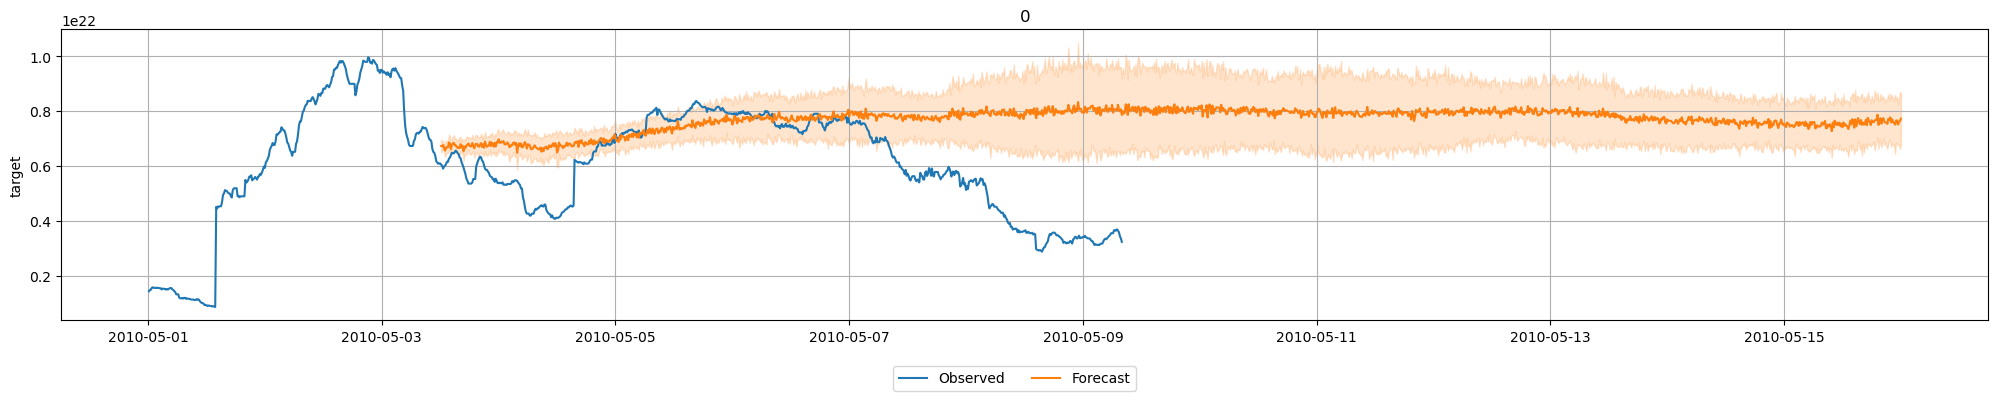

In [ ]:
predictor.plot(
    test_data.iloc[:1000,], 
    predictor.predict(orig_data.iloc[200:300,]), 
    quantile_levels = [0.1, 0.9],
    # max_history_length = prediction_length
    )

data with frequency 'None' has been resampled to frequency '12min'.
Model not specified in predict, will default to the model with the best validation score: PatchTST


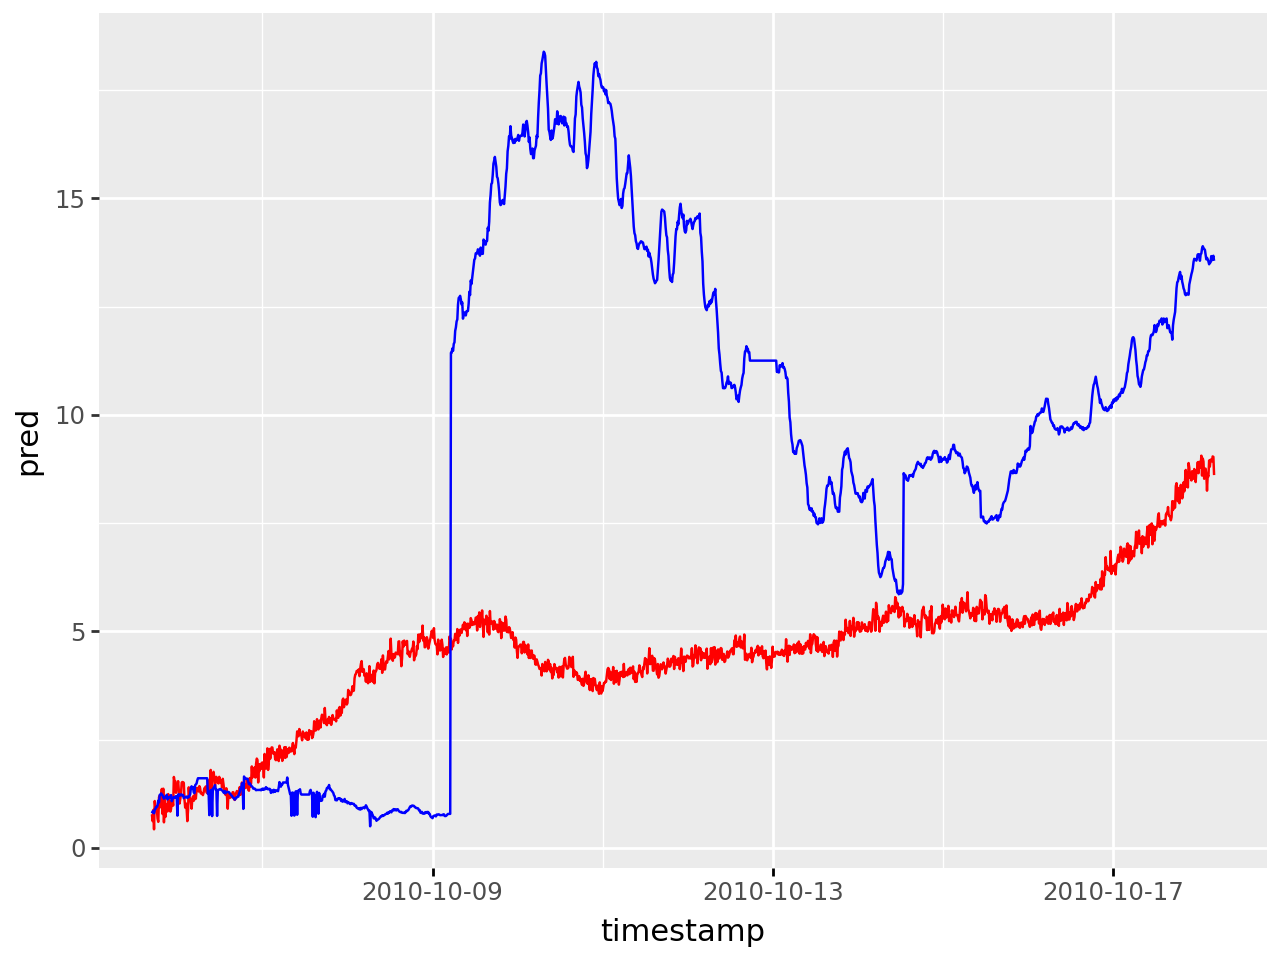

In [64]:
y_bar = predictor.predict(train_data)["mean"]
plot_df = pd.DataFrame( {
    "pred" : y_bar,
    "actual": test_data["target"].iloc[-prediction_length:,]
})

plot_df.reset_index(inplace=True)

plot_df = pd.DataFrame( {
    "pred" : y_bar,
    "actual": test_data["target"].iloc[-prediction_length:,]
})

plot_df.reset_index(inplace=True)

plot_df[["pred", "actual"]] = plot_df[["pred", "actual"]] / 1e21

(
    ggplot(data=plot_df, mapping= aes(x= "timestamp")) +
    geom_line(aes(y = "pred"), color = "red") + 
    geom_line(aes(y = "actual"), color = "blue")
)

#### <b> Function to compute coverage of CI </b>

In [3]:
def Compute_Coverage(data: pd.Series, input_window: int, predictor: TimeSeriesPredictor, stride: int, prediction_length: int):
    start_indices = list(range(0, len(data) - input_window, stride))
    end_indices = [start + input_window - 1 for start in start_indices]

    results = {}
    for start_index, end_index in zip(start_indices, end_indices):
        output = predictor.predict(data.iloc[start_index:end_index + 1]) 
        output["observation"] = data.iloc[(end_index + 1):(end_index + prediction_length + 1)  ] # append true value column
        # results
        ...

In [6]:
### testing

2. With Hyperparameter auto tuning

In [67]:
predictor = TimeSeriesPredictor(
    freq = "12T",
    prediction_length= prediction_length, # 200
    # known_covariates_names= known_covariates_names,
).fit(
    train_data,
    hyperparameters={
        "PatchTST": [
            {
                "target_scaler": "standard",
                "d_model": space.Int(16,48),
                "nhead": space.Int(2,8),
                "num_encoder_layers": space.Int(2,4),
                "context_length": space.Int(72, 124)
            }

        ]
    },

    hyperparameter_tune_kwargs = "auto",
    enable_ensemble= False,
    time_limit= 120,
    num_val_windows = 3,
    presets = "high_quality",
)

	Trained 2 models while tuning PatchTST.
	-0.5020       = Validation score (-WQL)
	125.01  s     = Total tuning time
Training complete. Models trained: ['PatchTST\\57de3648', 'PatchTST\\dfa39933']
Total runtime: 125.18 s
Best model: PatchTST\57de3648
Best model score: -0.5020


In [68]:
predictor.leaderboard(test_data)

data with frequency 'None' has been resampled to frequency '12min'.
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,PatchTST\57de3648,-0.478591,-0.502003,0.131001,0.162001,112.974388,1
1,PatchTST\dfa39933,-0.583408,-0.505891,0.106003,0.153995,101.413300,2


data with frequency 'None' has been resampled to frequency '12min'.
Model not specified in predict, will default to the model with the best validation score: PatchTST\57de3648
data with frequency 'None' has been resampled to frequency '12min'.


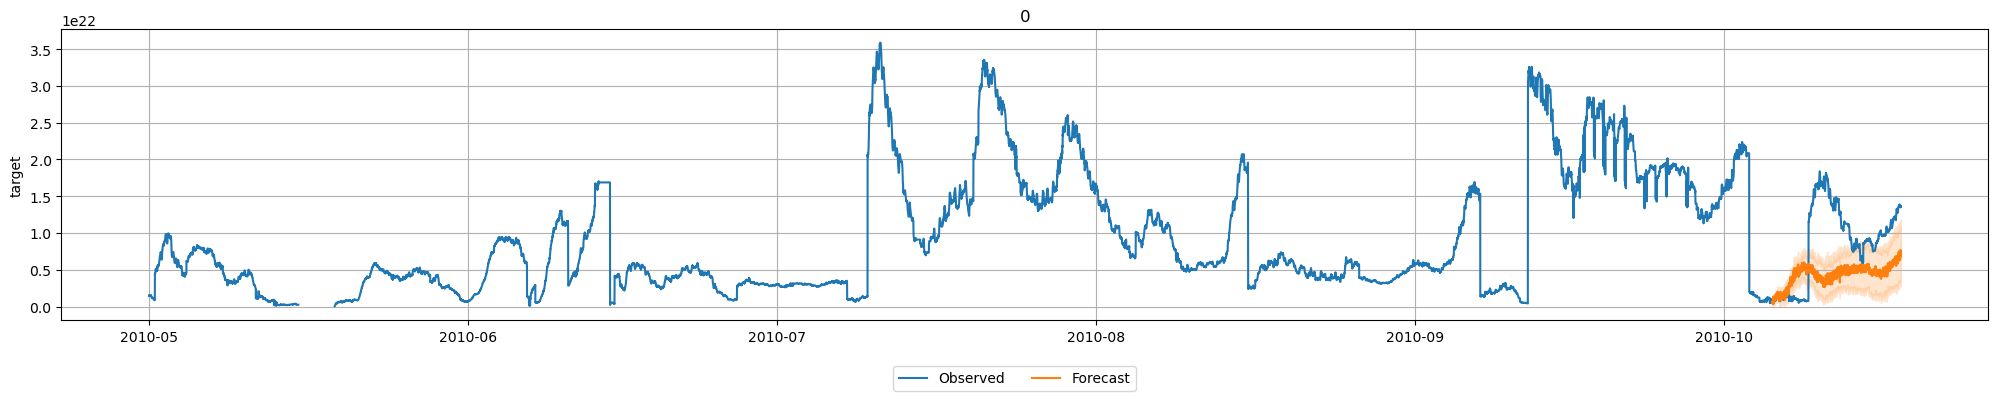

In [69]:
predictor.plot(
    test_data, 
    predictor.predict(train_data), 
    quantile_levels = [0.3, 0.7],
    # max_history_length = 200
    )

data with frequency 'None' has been resampled to frequency '12min'.
Model not specified in predict, will default to the model with the best validation score: PatchTST\57de3648


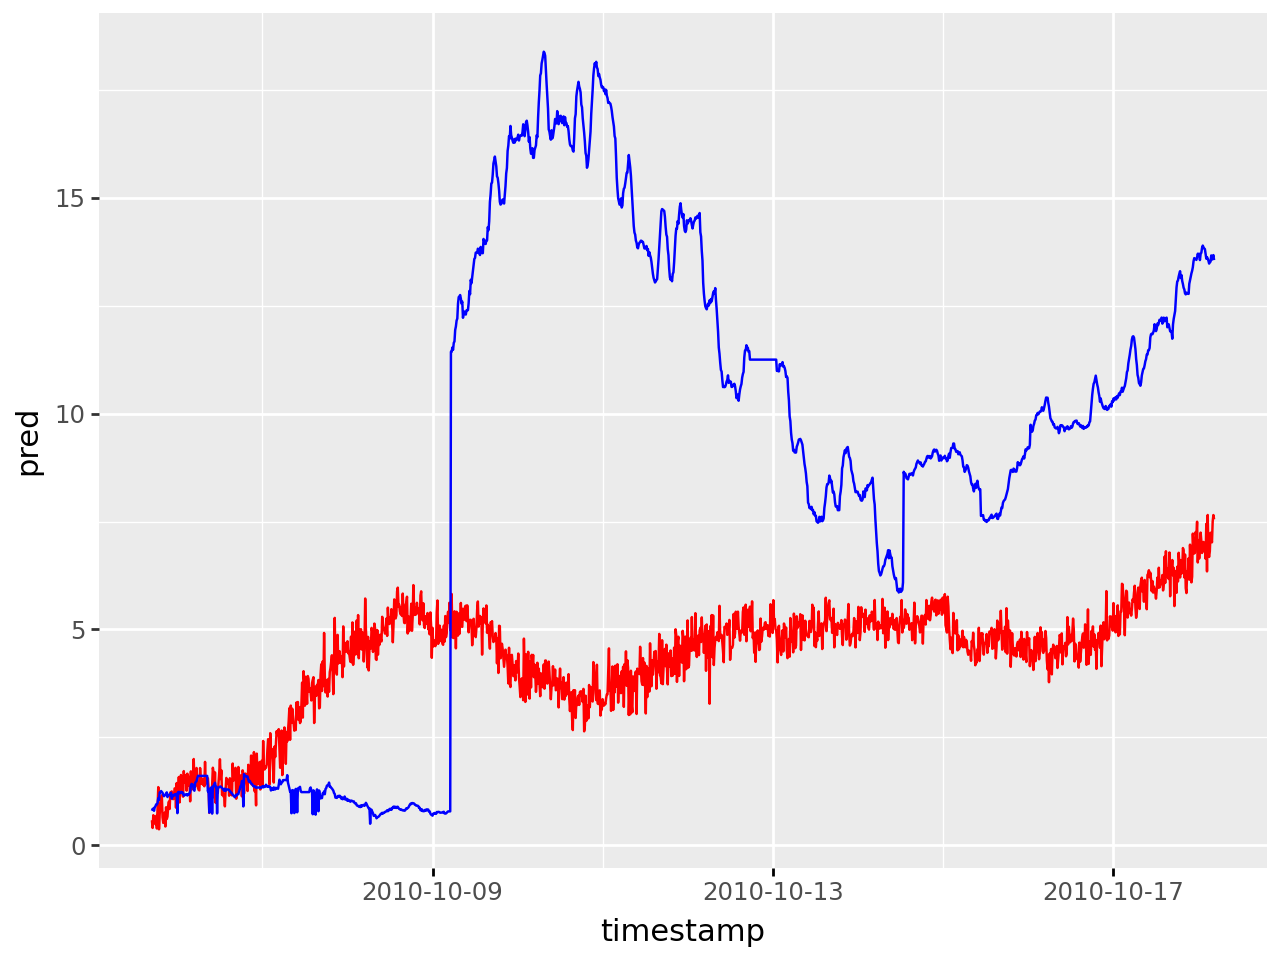

In [70]:
y_bar = predictor.predict(train_data)["mean"]
plot_df = pd.DataFrame( {
    "pred" : y_bar,
    "actual": test_data["target"].iloc[-prediction_length:,]
})

plot_df.reset_index(inplace=True)

plot_df = pd.DataFrame( {
    "pred" : y_bar,
    "actual": test_data["target"].iloc[-prediction_length:,]
})

plot_df.reset_index(inplace=True)

plot_df[["pred", "actual"]] = plot_df[["pred", "actual"]] / 1e21

(
    ggplot(data=plot_df, mapping= aes(x= "timestamp")) +
    geom_line(aes(y = "pred"), color = "red") + 
    geom_line(aes(y = "actual"), color = "blue")
)

### TemporalFusionTransformerModel
Combines LSTM with a transformer layer to predict the quantiles of all future target values

In [3]:
df_single_item = df.copy()
df_single_item['item_id'] = 0
df_single_item = df_single_item[[df_single_item.columns[-1]] + list(df_single_item.columns[:-1])]
df_single_item.rename(columns={'T_REC':'timestamp'}, inplace=True)
df_single_item['timestamp'] = df_single_item['timestamp'].dt.tz_localize(None)

df_single_item = df_single_item.ffill() # fill missing values with previous one
df_single_item = df_single_item.iloc[1:,] # drop the 1st row

df_single_item = df_single_item.iloc[:, 0:-3]
df_single_item = df_single_item.iloc[:10000,:]
df_single_item["target"] = df_single_item["USFLUX"]
df_single_item = df_single_item.drop(columns=["USFLUX"])
df_single_item = TimeSeriesDataFrame.from_data_frame(df_single_item)

prediction_length = 200 # smaller prediction_length performs better

train_data, test_data = df_single_item.train_test_split(prediction_length)

print(len(train_data), len(test_data))


9800 10000


In [4]:
known_covariates_names = df_single_item.columns[
    1:5
]
known_covariates_names

Index(['MEANGBT', 'MEANGBZ', 'MEANGBH', 'MEANJZD'], dtype='object')

In [5]:
predictor = TimeSeriesPredictor(
    freq = "12T",
    prediction_length= prediction_length, # 200
    known_covariates_names= known_covariates_names,
).fit(
    train_data,
    hyperparameters={
        
        "TemporalFusionTransformerModel": [
        
            {
                "target_scaler": "standard",
                "disable_static_features": True,
                "hidden_dim": space.Int(16,64),
                "variable_dim": space.Int(16,64),
                "dropout_rate": 0.2
            },
        ]
    },

    hyperparameter_tune_kwargs = "auto",
    enable_ensemble= False,
    time_limit= 120,
    num_val_windows = 3,
    presets = "high_quality",
)

	Trained 7 models while tuning TemporalFusionTransformer.
	-0.3438       = Validation score (-WQL)
	128.46  s     = Total tuning time
Training complete. Models trained: ['TemporalFusionTransformer\\4bcdb45f', 'TemporalFusionTransformer\\34c86667', 'TemporalFusionTransformer\\dab87c75', 'TemporalFusionTransformer\\ea140021', 'TemporalFusionTransformer\\9b7e3663', 'TemporalFusionTransformer\\a0f8532a', 'TemporalFusionTransformer\\23fa9485']
Total runtime: 131.59 s
Best model: TemporalFusionTransformer\dab87c75
Best model score: -0.3438


In [6]:
predictor.leaderboard(test_data)

data with frequency 'None' has been resampled to frequency '12min'.
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,TemporalFusionTransformer\dab87c75,-0.387719,-0.343850,0.145948,0.211995,90.154939,3
1,TemporalFusionTransformer\ea140021,-0.425867,-0.357968,0.116001,0.203004,76.937365,4
2,TemporalFusionTransformer\34c86667,-0.427296,-0.355897,0.117997,0.274004,92.757929,2
3,TemporalFusionTransformer\4bcdb45f,-0.463470,-0.360474,0.131544,0.239000,102.854160,1
4,TemporalFusionTransformer\9b7e3663,-0.492706,-0.384804,0.114000,0.326047,71.709291,5
5,TemporalFusionTransformer\23fa9485,-0.606858,-0.418943,0.183901,0.074998,40.660354,7
6,TemporalFusionTransformer\a0f8532a,-0.640351,-0.391994,0.143001,0.286045,66.433078,6


In [8]:
train_data

MEANGAM     MEANGBT     MEANGBZ    MEANGBH  \
item_id timestamp                                                           
0       2010-05-01 00:12:00  32.159885  137.783195  137.832428  59.383249   
        2010-05-01 00:24:00  32.006564  138.032814  137.932202  58.588763   
        2010-05-01 00:36:00  32.489844  136.413847  136.048735  59.049505   
        2010-05-01 00:48:00  31.843583  136.656334  136.326496  58.237536   
        2010-05-01 01:00:00  32.029743  136.771497  136.505656  58.079512   
...                                ...         ...         ...        ...   
        2010-07-25 03:48:00  41.384122  114.722587  113.477724  55.624706   
        2010-07-25 04:00:00  41.267529  114.720902  113.369988  55.479224   
        2010-07-25 04:12:00  41.413390  114.430402  112.977299  55.349842   
        2010-07-25 04:24:00  41.725696  113.610285  112.435397  54.980101   
        2010-07-25 04:36:00  41.434044  113.991994  112.389481  55.288191   

                              MEANJZD       TOTUSJZ   MEANALP   MEANJZH  \
item_id timestamp                                                         
0       2010-05-01 00:12:00  0.528793  2.065877e+12  0.001307 -0.000677   
        2010-05-01 00:24:00  0.355526  2.096785e+12  0.001291 -0.000588   
        2010-05-01 00:36:00  0.317466  2.190448e+12 -0.001002 -0.001128   
        2010-05-01 00:48:00  0.342064  2.305668e+12 -0.000914 -0.000872   
        2010-05-01 01:00:00  0.160927  2.233088e+12 -0.000352 -0.001005   
...                               ...           ...       ...       ...   
        2010-07-25 03:48:00  0.058739  2.598836e+13 -0.003166 -0.000961   
        2010-07-25 04:00:00  0.004321  2.564600e+13 -0.001286 -0.000351   
        2010-07-25 04:12:00  0.018106  2.588000e+13 -0.001146 -0.000325   
        2010-07-25 04:24:00 -0.047483  2.627458e+13 -0.001293 -0.000352   
        2010-07-25 04:36:00  0.043972  2.674956e+13 -0.002499 -0.000703   

                                 TOTUSJH    ABSNJZH  ...    MEANSHR  \
item_id timestamp                                    ...              
0       2010-05-01 00:12:00   103.413242   7.856525  ...  24.980931   
        2010-05-01 00:24:00   104.334118   7.313008  ...  24.549219   
        2010-05-01 00:36:00   105.544694   7.701448  ...  25.103040   
        2010-05-01 00:48:00   110.540304   7.308810  ...  24.838363   
        2010-05-01 01:00:00   107.304800   9.163647  ...  24.577836   
...                                  ...        ...  ...        ...   
        2010-07-25 03:48:00  1168.955774  42.430199  ...  33.822054   
        2010-07-25 04:00:00  1160.475038  24.235681  ...  33.666310   
        2010-07-25 04:12:00  1168.831030  23.843389  ...  33.807386   
        2010-07-25 04:24:00  1170.166965  22.563526  ...  34.163297   
        2010-07-25 04:36:00  1187.463485  29.819627  ...  33.866354   

                               SHRGT45           NPIX          SIZE  \
item_id timestamp                                                     
0       2010-05-01 00:12:00   7.166919   21385.121136   1908.233367   
        2010-05-01 00:24:00   6.112795   22631.582458   2019.510773   
        2010-05-01 00:36:00   7.290995   23156.134658   2066.389478   
        2010-05-01 00:48:00   6.565928   24186.736691   2158.422429   
        2010-05-01 01:00:00   6.317723   24679.478496   2202.451682   
...                                ...            ...           ...   
        2010-07-25 03:48:00  23.823761  138480.762482  12563.488677   
        2010-07-25 04:00:00  23.833388  138745.674669  12587.667963   
        2010-07-25 04:12:00  23.670428  138655.343685  12579.760182   
        2010-07-25 04:24:00  24.468196  138873.414413  12599.723527   
        2010-07-25 04:36:00  24.125330  139207.802585  12630.181262   

                                    AREA          NACR     SIZE_ACR  \
item_id timestamp                                                     
0       2010-05-01 00:12:00  1124.079598   1636.651525   146.04

data with frequency 'None' has been resampled to frequency '12min'.
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer\dab87c75
data with frequency 'None' has been resampled to frequency '12min'.


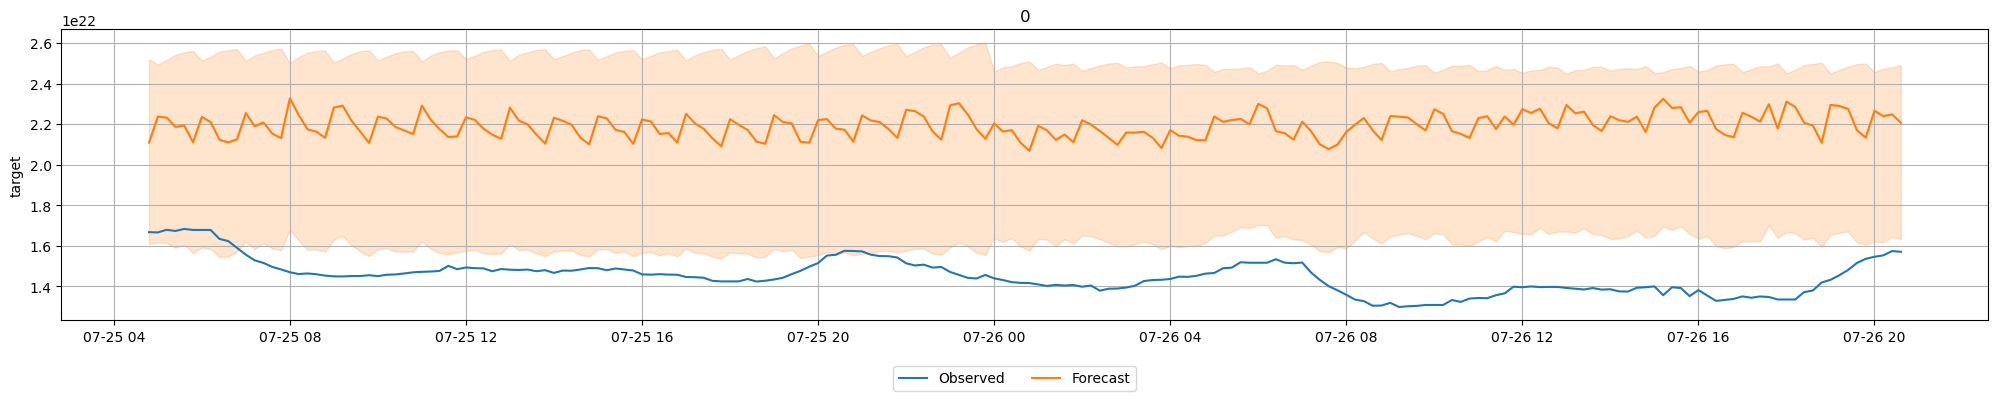

In [15]:
predictor.plot(
    test_data, 
    predictor.predict(train_data, 
                      known_covariates= test_data[known_covariates_names][-prediction_length:]), 
    quantile_levels = [0.3, 0.7],
    max_history_length = prediction_length
    )

data with frequency 'None' has been resampled to frequency '12min'.
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer\dab87c75


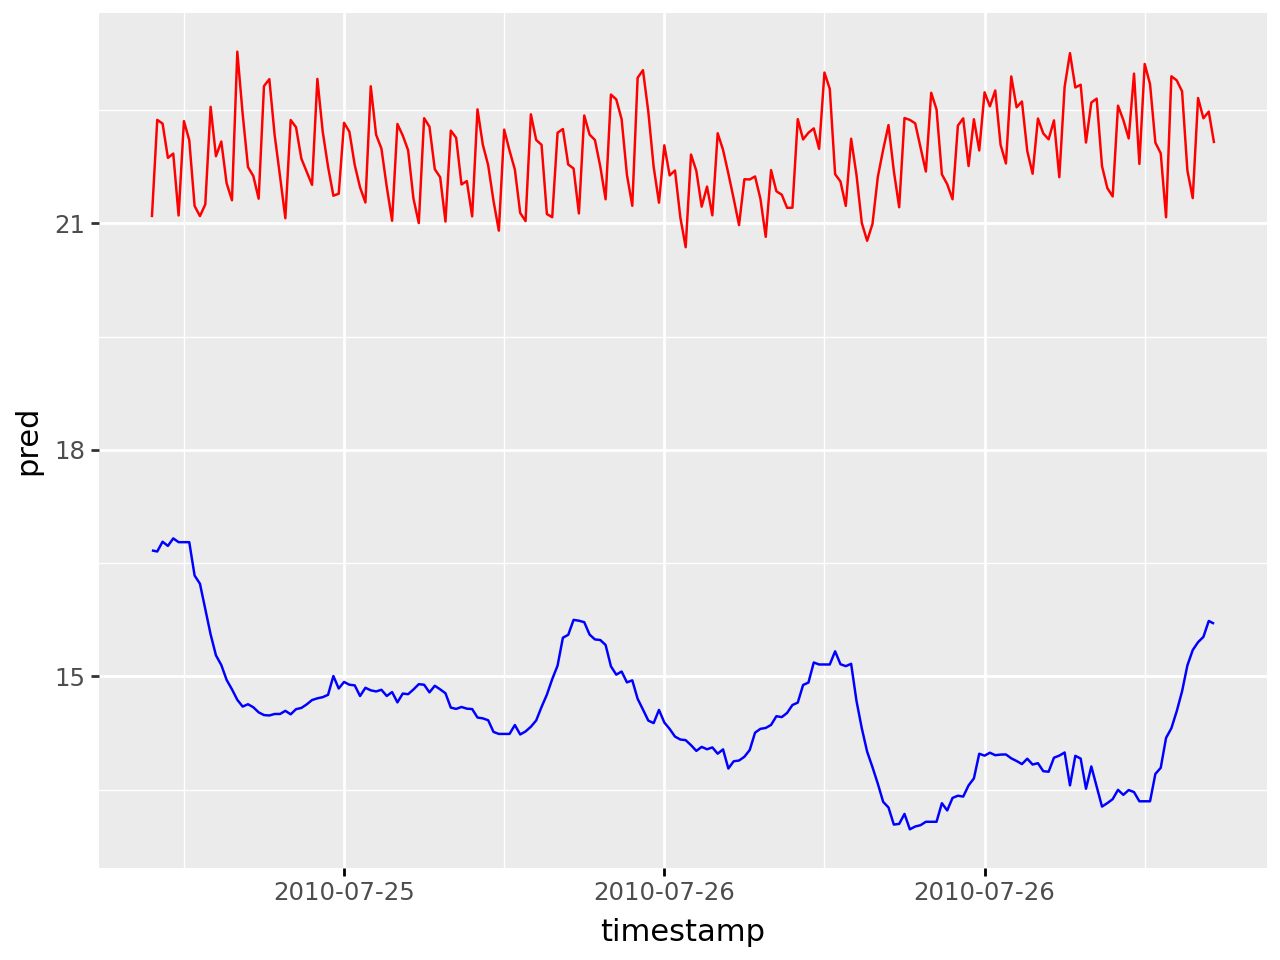

In [16]:
y_bar = predictor.predict(train_data,
                          known_covariates= test_data[known_covariates_names][-prediction_length:])["mean"]
plot_df = pd.DataFrame( {
    "pred" : y_bar,
    "actual": test_data["target"].iloc[-prediction_length:,]
})

plot_df.reset_index(inplace=True)

plot_df = pd.DataFrame( {
    "pred" : y_bar,
    "actual": test_data["target"].iloc[-prediction_length:,]
})

plot_df.reset_index(inplace=True)

plot_df[["pred", "actual"]] = plot_df[["pred", "actual"]] / 1e21

(
    ggplot(data=plot_df, mapping= aes(x= "timestamp")) +
    geom_line(aes(y = "pred"), color = "red") + 
    geom_line(aes(y = "actual"), color = "blue")
)